# ARCFACE MODEL
Ce code est une implémentation en Python du modèle ARCFACE, un modèle de reconnaissance faciale basé sur l'apprentissage en profondeur. Le modèle utilise la ResNet34 comme architecture de base pour extraire les caractéristiques de l'image, puis utilise une couche de normalisation et une couche de classification pour produire un vecteur d'embedding de 512 dimensions qui représente l'image d'entrée. Les poids pré-entraînés du modèle sont téléchargés depuis un dépôt Github et chargés lors de l'exécution du modèle.

In [19]:
# ARCFACE MODEL
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io
import tensorflow
from tensorflow import keras

import os
from pathlib import Path
import gdown

def loadModel():
	base_model = ResNet34()
	inputs = base_model.inputs[0]
	arcface_model = base_model.outputs[0]
	arcface_model = keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
	arcface_model = keras.layers.Dropout(0.4)(arcface_model)
	arcface_model = keras.layers.Flatten()(arcface_model)
	arcface_model = keras.layers.Dense(512, activation=None, use_bias=True, kernel_initializer="glorot_normal")(arcface_model)
	embedding = keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5, name="embedding", scale=True)(arcface_model)
	model = keras.models.Model(inputs, embedding, name=base_model.name)
	
	#---------------------------------------
	#check the availability of pre-trained weights
	
# 	home = str(Path.home())
	
# 	url = "https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5"
# 	file_name = "arcface_weights.h5"
# 	output = home+'/.deepface/weights/'+file_name
# 	Path(home+'/.deepface/weights/').mkdir(parents=True, exist_ok=True)
# 	if os.path.isfile(output) != True:

# 		print(file_name," will be downloaded to ",output)
# 		gdown.download(url, output, quiet=False)	
	
# 	#---------------------------------------
	
	try:
		model.load_weights('arcface_weights.h5')
	except:
		print("pre-trained weights could not be loaded.")
		print("You might try to download it from the url ", url," and copy to ",output," manually")
	
	return model
	
def ResNet34():
	
	img_input = tensorflow.keras.layers.Input(shape=(112, 112, 3))
	
	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = tensorflow.keras.layers.Conv2D(64, 3, strides=1, use_bias=False, kernel_initializer='glorot_normal', name='conv1_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = tensorflow.keras.layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)
		
	model = training.Model(img_input, x, name='ResNet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = tensorflow.keras.layers.Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = tensorflow.keras.layers.Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = tensorflow.keras.layers.PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = tensorflow.keras.layers.Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = tensorflow.keras.layers.Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

In [1]:
!pip install tensorflow

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
     ------------------------------------ 272.9/272.9 MB 248.9 kB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 2.6/2.6 MB 729.2 kB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 537.2 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Using 

  DEPRECATION: wrapt is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install mtcnn

  Using cached mtcnn-0.1.1-py3-none-any.whl (2.3 MB)



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install gdown

  Using cached gdown-4.7.1-py3-none-any.whl (15 kB)
     -------------------------------------- 143.0/143.0 kB 4.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np
%matplotlib inline

In [21]:
model = loadModel()
face_detector = MTCNN()

# La fonction `detect_face` permet de détecter un visage dans une image à l'aide de l'algorithme MTCNN (Multi-Task Cascaded Convolutional Networks). Voici une explication de chaque étape de la fonction :

- La première ligne de la fonction convertit l'image en entrée de l'espace de couleur BGR à l'espace de couleur RGB, car MTCNN s'attend à une image RGB.

- La deuxième ligne utilise l'algorithme MTCNN pour détecter les visages dans l'image. Le résultat est une liste de détections, où chaque détection contient les coordonnées du rectangle qui encadre le visage détecté, ainsi que la confiance de cette détection.

- La troisième ligne sélectionne la première détection de la liste (en supposant qu'il n'y a qu'un seul visage dans l'image).

- Les quatrième et cinquième lignes extraient les coordonnées du rectangle encadrant le visage détecté, puis utilise ces coordonnées pour extraire la zone de l'image correspondant au visage détecté.

- Enfin, la fonction retourne l'image du visage détecté.

# En somme, cette fonction est utile pour extraire automatiquement le visage dans une image pour des tâches telles que la reconnaissance faciale, la détection de visages, ou d'autres applications de traitement d'images qui nécessitent une détection de visage précise.

In [22]:
def detect_face(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #mtcnn expects RGB but OpenCV read BGR
    detections = face_detector.detect_faces(img_rgb)
    detection = detections[0]
    x, y, w, h = detection["box"]
    detected_face = img[int(y):int(y+h), int(x):int(x+w)]
    return detected_face

# La fonction `preprocess_face` est utilisée pour prétraiter une image de visage avant de la donner en entrée à un modèle de reconnaissance faciale. 

Voici ce que chaque ligne de la fonction fait:

1. Elle prend en entrée une image de visage.

2. Elle lit l'image en utilisant la fonction "cv2.imread" de la bibliothèque OpenCV.

3. Elle détecte le visage dans l'image en utilisant la fonction "detect_face" définie dans la fonction précédente.

4. Elle redimensionne le visage détecté à la taille spécifiée dans l'argument "target_size" en utilisant la fonction "cv2.resize".

5. Elle convertit l'image redimensionnée en un tableau de pixels en utilisant la fonction "image.img_to_array" de la bibliothèque Keras.

6. Elle ajoute une dimension au tableau de pixels pour obtenir une forme (1, largeur, hauteur, nombre de canaux) en utilisant la fonction "np.expand_dims" de la bibliothèque NumPy.

7. Elle normalise les valeurs des pixels pour qu'elles soient comprises entre 0 et 1 en divisant le tableau de pixels par 255.

8. Elle renvoie le tableau de pixels résultant en tant que sortie de la fonction. 

# En résumé, cette fonction prend en entrée une image de visage, la détecte et la redimensionne, puis renvoie un tableau de pixels normalisé prêt à être utilisé comme entrée pour un modèle de reconnaissance faciale.

In [23]:
def preprocess_face(img, target_size=(112,112)):
    img = cv2.imread(img)
    img = detect_face(img)
    img = cv2.resize(img, target_size)
    img_pixels = image.img_to_array(img)
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255 #normalize input in [0, 1]
    return img_pixels

# La fonction de img_to_encoding :
prend en entrée un chemin vers une image, la pré-traite à l'aide de la fonction "preprocess_face" (redimensionnement, détection de visage et normalisation), et la passe ensuite dans un modèle de reconnaissance faciale (préalablement entraîné) pour obtenir une représentation vectorielle (encodage) de l'image. Cette représentation vectorielle permet de comparer les similitudes entre les visages, en calculant par exemple la distance euclidienne entre deux encodages.

In [24]:
def img_to_encoding(path):
    img = preprocess_face(path)
    return model.predict(img)[0]

# DataBase

In [25]:
database = {}
database["tebboune"] = img_to_encoding("./images/4.jpg")
database["Obama"] = img_to_encoding("./images/1.jpg")


1/1 [==============================] - 2s 2s/step


# Cette fonction calcule la distance euclidienne entre deux vecteurs de représentation faciale : 
`source_representation` et `test_representation`. La distance euclidienne est calculée en soustrayant le vecteur de représentation du test de celui de la source, en multipliant chaque différence par elle-même, en prenant la somme de ces carrés et en trouvant la racine carrée de cette somme. La valeur de la distance euclidienne est renvoyée en sortie.

In [26]:
def EuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [27]:
verification_threshhold = 4.4

## La fonction `verify`
effectue une vérification de l'identité d'une personne en comparant la distance entre l'encodage de l'image fournie et l'encodage de l'identité stockée dans une base de données. Les étapes effectuées sont les suivantes:

1. Calcul de l'encodage de l'image fournie en utilisant la fonction `img_to_encoding()`.
2. Calcul de la distance euclidienne entre l'encodage de l'image fournie et l'encodage de l'identité stockée dans la base de données en utilisant la fonction `EuclideanDistance()`.
3. Si la distance est inférieure à un seuil de vérification prédéfini (`verification_threshold`), la porte est ouverte et l'identité est confirmée. Sinon, la porte reste fermée et la fonction `who_is_it()` est appelée pour afficher les identités les plus proches à partir de la base de données. Enfin, l'image fournie est affichée.

La fonction renvoie la distance euclidienne calculée.

In [28]:
import cv2
import matplotlib.pyplot as plt


def verify(image_path, identity, database):
    # Step 1: Compute the encoding for the image. Use img_to_encoding()
    encoding = img_to_encoding(image_path) 
    
    # Step 2: Compute distance with identity's image
    dist = EuclideanDistance(encoding, database[identity])
    
    # Step 3: Open the door if dist < verification_threshhold, else don't open
    if dist < verification_threshhold:
        print("It's " + str(identity) + ", ` welcome! `")
         # Display the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
    else:
        print("It's not " + str(identity) + ", please go away")
        who_is_it(image_path, database)
    
   
    
    return dist

## La fonction `who_is_it` :
prend en entrée le chemin d'une image à vérifier et une base de données de visages encodés. Elle utilise la fonction `img_to_encoding` pour encoder l'image d'entrée. Ensuite, elle boucle sur la base de données pour trouver le visage le plus proche de l'image encodée en calculant la distance euclidienne entre les deux. Si la distance est inférieure au seuil de vérification (`verification_threshhold`), elle renvoie l'identité du visage trouvé. Sinon, elle indique que le visage n'est pas dans la base de données. 

La fonction renvoie la distance minimale entre l'image d'entrée et la base de données ainsi que l'identité du visage le plus proche.

In [29]:
def who_is_it(image_path, database):
   
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding()
    encoding = img_to_encoding(image_path)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 
    min_dist = 1000
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = EuclideanDistance(encoding, db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if min_dist > dist:
            min_dist = dist
            identity = name

  
    if min_dist > verification_threshhold:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        # Display the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        
    return min_dist, identity



##                                      test





1/1 [==============================] - 1s 1s/step
It's Obama, ` welcome! `


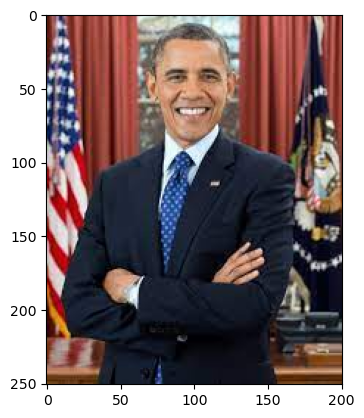

3.5235724

In [30]:
verify("images/2.jpg", "Obama", database)

1/1 [==============================] - 1s 1s/step
It's tebboune, ` welcome! `


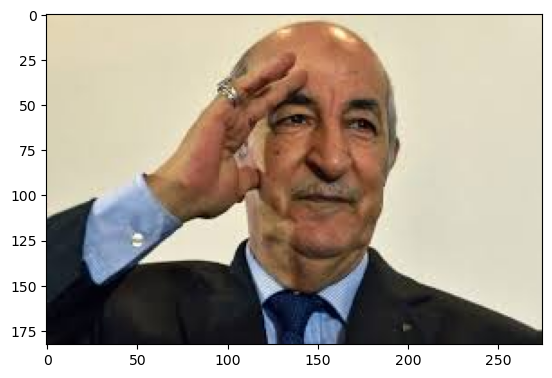

4.1192136

In [15]:
verify("images/5.jpg", "tebboune", database)

1/1 [==============================] - 1s 1s/step
It's not Obama, please go away
1/1 [==============================] - 1s 1s/step
it's tebboune, the distance is 3.7726195


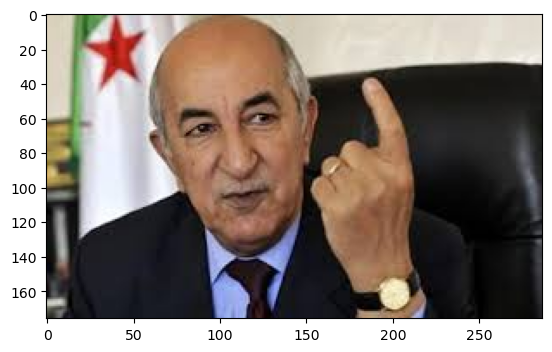

5.3753543

In [16]:
verify("images/6.jpg", "Obama", database)

1/1 [==============================] - 1s 1s/step
it's tebboune, the distance is 4.3283663


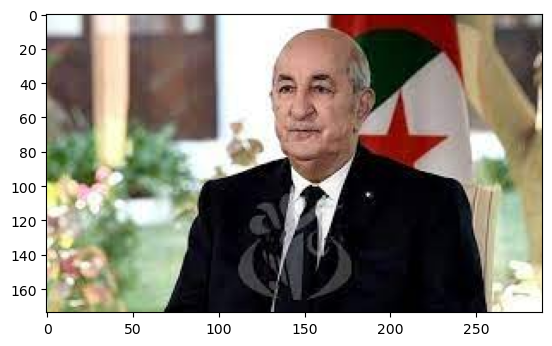

(4.3283663, 'tebboune')

In [31]:
who_is_it("images/3.jpg", database)

1/1 [==============================] - 1s 1s/step
it's Obama, the distance is 0.0


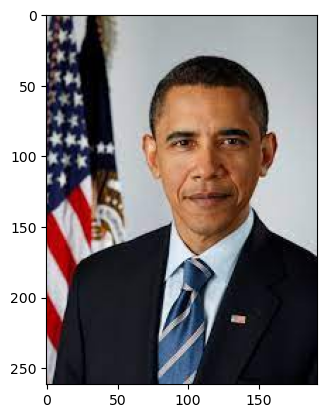

(0.0, 'Obama')

In [18]:
who_is_it("images/1.jpg", database)